In [8]:
# ECE60146 HW6
# Zhengxin Jiang
# jiang839

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import seaborn as sn 
import random
import json
import math

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as tvt
from torch.utils.data import DataLoader

import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [25]:
# Function for preparing the image data
def prepData(coco, root, tasktype):
    
    if tasktype == 'training':
        rawDataDir = os.path.join(root, 'train2014').replace("\\","/")
        hwDataDir = os.path.join(root, 'hw6', 'train').replace("\\","/")
        
    if tasktype == 'validation':
        rawDataDir = os.path.join(root, 'val2014').replace("\\","/")
        hwDataDir = os.path.join(root, 'hw6', 'val').replace("\\","/")
    
    bbox_total = []
    label_total = []
    selectedImgIds = []
    imgCount = 0
    
    catIds = coco.getCatIds(catNms=['bus','cat','pizza'])
    coco_labels_inverse = {}
    for i, catid in enumerate(catIds):
        coco_labels_inverse[catid] = i
    
    # go through the images
    for catCount,catId in enumerate(catIds):
        
        ImgIds = coco.getImgIds(catIds=catId)
        
        for imgId in ImgIds:
            
            if imgId in selectedImgIds:
                continue
               
            coco_img = coco.loadImgs(imgId)[0]
            annId = coco.getAnnIds(imgIds=coco_img['id'], catIds=catIds, iscrowd=None)
            anns = coco.loadAnns(annId)
            
            # check if the image is valid
            is_valid = 0
            anns_valid = []
            
            for ann in anns:
                if ann['area'] > 4096:
                    is_valid = 1
                    anns_valid.append(ann)
                    
            if is_valid==0:
                continue
            
            imgName = coco_img['file_name']
            img = Image.open(os.path.join(rawDataDir, imgName).replace("\\","/"))
            
            # save bbox and labels
            img_bbox = []
            img_labels = []
            
            for ann in anns_valid:
                bbox = ann['bbox']
                label = coco_labels_inverse[ann['category_id']]
                
                resize_ratio = (256/img.size[0], 256/img.size[1])
                bbox_resized = np.zeros(4)
                bbox_resized[0] = bbox[0]*resize_ratio[0]
                bbox_resized[2] = bbox[2]*resize_ratio[0]
                bbox_resized[1] = bbox[1]*resize_ratio[1]
                bbox_resized[3] = bbox[3]*resize_ratio[1]
                
                bbox_resized[2:] += bbox_resized[:2]        # change the format to [x1, y1, x2, y2]
                bbox_resized[2:] -= 1e-3
                bbox_resized[:2] += 1e-3                    # let bbox reside in (0,1)
                
                img_bbox.append(list(bbox_resized))
                img_labels.append(label)
                
            bbox_total.append(img_bbox)
            label_total.append(img_labels)
    
            if img.mode != "RGB":
                img = img.convert(mode="RGB")
            img = img.resize((256, 256), Image.BOX)
            
            imgNewName = str(imgCount) + '.jpg'
            fp = open(os.path.join(hwDataDir, imgNewName).replace("\\","/"), 'w')
            img.save(fp)
            
            #update
            imgCount += 1
            selectedImgIds.append(imgId)
    
    with open('{}/bbox'.format(hwDataDir), 'w') as fp:
        json.dump(bbox_total, fp)
    with open('{}/labels'.format(hwDataDir), 'w') as fp:
        json.dump(label_total, fp)    
    
               
    return       
    
    
# The Dataset class for hw5
class hwDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, tasktype):
        super().__init__()
        
        if tasktype == 'training':
            self.root = os.path.join(root, 'hw6', 'train').replace("\\","/")  
        if tasktype == 'validation':
            self.root = os.path.join(root, 'hw6', 'val').replace("\\","/")
        
        with open(os.path.join(self.root, 'bbox').replace("\\","/"), 'r') as fp:
            self.bbox = json.load(fp)
        with open(os.path.join(self.root, 'labels').replace("\\","/"), 'r') as fp:
            self.labels = json.load(fp)
            
        len_list = []
        for i, item in enumerate(self.labels):
            len_list.append(len(item))
            
        self.maxobjcount = max(len_list)
            
        
    def __len__(self):
        return len(os.listdir(self.root))-2  # Total files minus the two json file
        
    def __getitem__(self, index):   
        
        name = str(index)+'.jpg'
        
        img = Image.open(os.path.join(self.root, name).replace("\\","/"))
        
        tr = tvt.Compose([
            tvt.ToTensor(),
            tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        img_tensor = tr(img)
        label = self.labels[index]
        bb_scaled = np.array(self.bbox[index])/256
        
        cellIdx = []
        aboxIdx = []
        yoloVector = []
        
        yolo_tensor = torch.zeros(num_yolo_cells, num_anchor_boxes, 8)
        
        for i in range(len(label)):
            bb_w = bb_scaled[i][2] - bb_scaled[i][0]
            bb_h = bb_scaled[i][3] - bb_scaled[i][1]
            bb_center_w = (bb_scaled[i][0]+bb_scaled[i][2])/2
            bb_center_h = (bb_scaled[i][1]+bb_scaled[i][3])/2

            # 6*6 cells and 5 anchorbox for each cell
            cell_w = 1/6
            cellidx_i = int(bb_center_w / cell_w)
            cellidx_j = int(bb_center_h / cell_w)
            cellidx = cellidx_j*6 + cellidx_i
            cell_center_w = (cellidx_i + 0.5) * cell_w
            cell_center_h = (cellidx_j + 0.5) * cell_w
            del_w = bb_center_w - cell_center_w
            del_h = bb_center_h - cell_center_h

            ar = bb_h / bb_w
            if ar <= 0.2:   
                aboxidx = 0
                sigma_w = math.log(bb_w/(cell_w*5))
                sigma_h = math.log(bb_h/(cell_w))
            if 0.2 < ar <= 0.5:
                aboxidx = 1
                sigma_w = math.log(bb_w/(cell_w*3))
                sigma_h = math.log(bb_h/(cell_w))
            if 0.5 < ar <= 1.5:
                aboxidx = 2
                sigma_w = math.log(bb_w/(cell_w))
                sigma_h = math.log(bb_h/(cell_w))
            if 1.5 < ar <= 4.0:
                aboxidx = 3
                sigma_w = math.log(bb_w/(cell_w))
                sigma_h = math.log(bb_h/(cell_w*3))
            if 4.0 < ar :
                aboxidx = 4
                sigma_w = math.log(bb_w/(cell_w))
                sigma_h = math.log(bb_h/(cell_w*5))

            # construct yolo vector
            yolo_vector = torch.tensor([1, del_w, del_h, sigma_w, sigma_h, 0, 0, 0])
            yolo_vector[5+label[i]] = 1
                
            yolo_tensor[cellidx, aboxidx] = yolo_vector

        return img_tensor, yolo_tensor
    
    
# The Resnet block with skip connection 
class ResnetBlock(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(ResnetBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
            
            
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn(self.conv(x)))
        out = self.bn(self.conv(out))
        out += identity   #skip connection
        out = F.relu(out)
        
        return out
    
    
class HW6Net(nn.Module):
    
    def __init__(self, ngf=8, n_blocks=4):
        super(HW6Net, self).__init__()
        
        # The first conv layer
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(3, ngf, kernel_size=7, padding=0),
                 nn.BatchNorm2d(ngf),
                 nn.ReLU(True)]
        
        # Add downsampling layers
        n_downsampling = 5
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size=3, stride=2, padding=1), 
                      nn.BatchNorm2d(ngf*mult*2), 
                      nn.ReLU(True)]
    
        # My own ResNet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf*mult, ngf*mult)]
        self.model = nn.Sequential(*model)
        
        wh = int(256/mult)
        
        # output a yolo tensor
        yolo_head = [nn.Flatten(),
                      nn.Linear(ngf*mult*wh*wh, 4096),
                      nn.ReLU(True),
                      nn.Linear(4096, 2048), 
                      nn.ReLU(True),
                      nn.Linear(2048, 1620)]
        self.yolo_head = nn.Sequential(*yolo_head)
        
    def forward(self, x):
        ft = self.model(x)
        yolotensor = self.yolo_head(ft)
        
        return yolotensor
    

    
# Recover the original bbox
def bboxRecovery(cell_idx, anchbox_idx, yolovec):
    
    cell_idx_i = cell_idx % 6
    cell_idx_j = cell_idx // 6

    cell_w = 1/6
    bbox_center_w = (cell_idx_i+0.5)*cell_w + yolovec[1]
    bbox_center_h = (cell_idx_j+0.5)*cell_w + yolovec[2]

    if anchbox_idx == 0:   
        bbox_w = math.exp(yolovec[3])*cell_w*5
        bbox_h = math.exp(yolovec[4])*cell_w
    if anchbox_idx == 1:   
        bbox_w = math.exp(yolovec[3])*cell_w*3
        bbox_h = math.exp(yolovec[4])*cell_w
    if anchbox_idx == 2:   
        bbox_w = math.exp(yolovec[3])*cell_w
        bbox_h = math.exp(yolovec[4])*cell_w
    if anchbox_idx == 3:   
        bbox_w = math.exp(yolovec[3])*cell_w
        bbox_h = math.exp(yolovec[4])*cell_w*3
    if anchbox_idx == 4:   
        bbox_w = math.exp(yolovec[3])*cell_w
        bbox_h = math.exp(yolovec[4])*cell_w*5

    bbox_raw = 256 * np.array([bbox_center_w - bbox_w/2, bbox_center_h - bbox_h/2, bbox_center_w + bbox_w/2, bbox_center_h + bbox_h/2])   
    bbox_raw = bbox_raw.astype(int)
    
    return bbox_raw


def drawBBox(img, label, gt, color):
    
    class_name = ['bus', 'cat', 'pizza']
    
    if color == 'r':
        cl = (36, 12, 255)
    if color == 'g':
        cl = (36, 255, 12)

    img = cv2.rectangle(img, (int(gt[0]), int(gt[1])), (int(gt[2]), int(gt[3])), cl, 2)
    img = cv2.putText(img, class_name[label], (int(gt[0]), int(gt[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, cl, 2)
    
    return img
    

In [13]:
# global variables
num_yolo_cells = 36
num_anchor_boxes = 5
batch_size = 4
epochs = 20

In [51]:
coco_train = COCO('{}/train2014/annotations/instances_train2014.json'.format(root))
coco_val = COCO('{}/val2014/annotations/instances_val2014.json'.format(root)) 

loading annotations into memory...
Done (t=9.93s)
creating index...
index created!
loading annotations into memory...
Done (t=4.11s)
creating index...
index created!


In [14]:
root = 'D:/coco'

In [68]:
prepData(coco_train, root, 'training')

In [69]:
prepData(coco_val, root, 'validation')

In [15]:
#### Training ####
traindataset = hwDataset(root, 'training')
train_data_loader = DataLoader(traindataset, batch_size=batch_size, num_workers=0, shuffle=True)

net = HW6Net()
net = net.to(device)

criterion1 = torch.nn.BCELoss()
criterion2 = torch.nn.MSELoss()
criterion3 = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.99))

bce_loss_list = []
mse_loss_list = []
label_loss_list = [] 

for epoch in range(epochs): 
#     running_loss = 0.0 
    bce_running_loss = 0.0 
    mse_running_loss = 0.0 
    label_running_loss = 0.0 
    
    for i, data in enumerate(train_data_loader):
        inputs, yoloTensor = data
        
        inputs = inputs.to(device)
        yoloTensor = yoloTensor.to(device)

        yoloTensor_aug = torch.zeros(batch_size, num_yolo_cells, num_anchor_boxes, 9).to(device)
        yoloTensor_aug[:,:,:,:-1] = yoloTensor
        
        ## get indices of yolo vectors
        obj_indices = torch.nonzero(yoloTensor[:,:,:,0])
        nonobj_indices = torch.nonzero(yoloTensor[:,:,:,0]==0)
        
        ## assign prob mass for no object
        for nonobj_idx in nonobj_indices:
            yoloTensor_aug[tuple(nonobj_idx)][-1] = 1

                        
        optimizer.zero_grad()
        outputs = net(inputs)
        prediction_aug = outputs.view(batch_size, num_yolo_cells, num_anchor_boxes, 9)
        
#         loss = torch.tensor(0.0, requires_grad=True).float().to(device)
        BCEloss = torch.tensor(0.0, requires_grad=True).float().to(device)
        MSEloss = torch.tensor(0.0, requires_grad=True).float().to(device)
        Labelloss = torch.tensor(0.0, requires_grad=True).float().to(device)
        
        for obj_idx in obj_indices:
            yolovec_pred = prediction_aug[tuple(obj_idx)]
            yolovec_gt = yoloTensor_aug[tuple(obj_idx)]
            
            object_presence = nn.Sigmoid()(torch.unsqueeze(yolovec_pred[0], dim=0))
            target = torch.unsqueeze(yolovec_gt[0], dim=0)
            bceloss = criterion1(object_presence, target)
            BCEloss += bceloss
#             loss += bceloss
            
            pred_regression = torch.unsqueeze(yolovec_pred[1:5], dim=0) 
            target_regression = torch.unsqueeze(yolovec_gt[1:5], dim=0) 
            regloss = criterion2(pred_regression, target_regression)
            MSEloss += regloss
#             loss += regloss
            
            pred_probvec = torch.unsqueeze(yolovec_pred[5:], dim=0) 
            target_probvec = torch.unsqueeze(yolovec_gt[5:], dim=0) 
            labelloss = criterion3(pred_probvec, target_probvec)
            Labelloss += labelloss
#             loss += labelloss
        
        BCEloss.backward(retain_graph=True)
        MSEloss.backward(retain_graph=True)
        Labelloss.backward()
#         loss.backward()
        optimizer.step()
    
        bce_running_loss += BCEloss.item()    
        mse_running_loss += MSEloss.item()    
        label_running_loss += Labelloss.item()    
#         running_loss += loss.item()    
        if (i+1) % 500 == 0:
            print("[ epoch : %d, batch : %5d] BCEloss : %.4f" % (epoch + 1, i + 1, bce_running_loss / 500))
            bce_loss_list.append(bce_running_loss)
            bce_running_loss = 0.0
            print("[ epoch : %d, batch : %5d] MSEloss : %.4f" % (epoch + 1, i + 1, mse_running_loss / 500))
            mse_loss_list.append(mse_running_loss)
            mse_running_loss = 0.0
            print("[ epoch : %d, batch : %5d] Labelloss : %.4f" % (epoch + 1, i + 1, label_running_loss / 500))
            label_loss_list.append(label_running_loss)
            label_running_loss = 0.0
        
        
        
        
        
        
        
        

[ epoch : 1, batch :   500] BCEloss : 0.7002
[ epoch : 1, batch :   500] MSEloss : 0.8424
[ epoch : 1, batch :   500] Labelloss : 5.5777
[ epoch : 1, batch :  1000] BCEloss : 0.2931
[ epoch : 1, batch :  1000] MSEloss : 0.6945
[ epoch : 1, batch :  1000] Labelloss : 4.4696
[ epoch : 1, batch :  1500] BCEloss : 0.2004
[ epoch : 1, batch :  1500] MSEloss : 0.6697
[ epoch : 1, batch :  1500] Labelloss : 4.0190
[ epoch : 2, batch :   500] BCEloss : 0.1327
[ epoch : 2, batch :   500] MSEloss : 0.6688
[ epoch : 2, batch :   500] Labelloss : 3.1610
[ epoch : 2, batch :  1000] BCEloss : 0.1023
[ epoch : 2, batch :  1000] MSEloss : 0.6659
[ epoch : 2, batch :  1000] Labelloss : 2.7585
[ epoch : 2, batch :  1500] BCEloss : 0.0945
[ epoch : 2, batch :  1500] MSEloss : 0.5885
[ epoch : 2, batch :  1500] Labelloss : 2.6840
[ epoch : 3, batch :   500] BCEloss : 0.0749
[ epoch : 3, batch :   500] MSEloss : 0.5810
[ epoch : 3, batch :   500] Labelloss : 2.2617
[ epoch : 3, batch :  1000] BCEloss : 0.0

In [16]:
torch.save(net.state_dict(), '20e.pth')

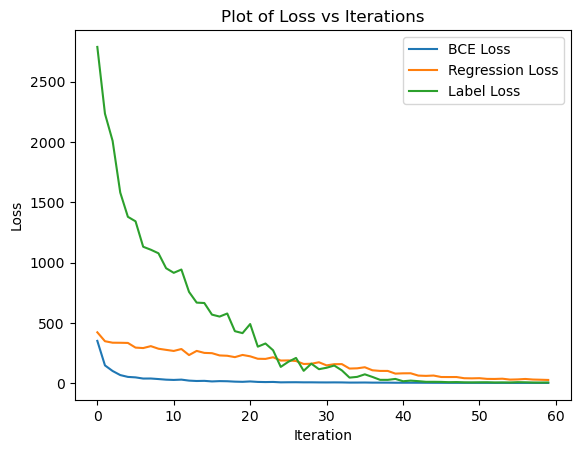

In [42]:
## plot the training loss
plt.plot(bce_loss_list, label='BCE Loss')
plt.plot(mse_loss_list, label='Regression Loss')
plt.plot(label_loss_list, label='Label Loss')
plt.legend()
plt.title("Plot of Loss vs Iterations")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [41]:
#### Validation ####
valdataset = hwDataset(root, 'validation')
val_data_loader = DataLoader(valdataset, batch_size=1, num_workers=0, shuffle=False)

# net = HW6Net()
# net = net.to(device)
# ## load trained parameters 
# net.load_state_dict(torch.load('20e.pth', map_location=torch.device(device))) 


with torch.no_grad():
    for i, data in enumerate(val_data_loader):
        
        inputs, yoloTensor = data
        
        inputs = inputs.to(device)
        
        outputs = net(inputs)
        prediction_aug = outputs.view(1, num_yolo_cells, num_anchor_boxes, 9)
        prediction_aug = prediction_aug.to('cpu')
        
        imgname = '{}.jpg'.format(i)
        img = cv2.imread(os.path.join(root, 'hw6', 'val', imgname).replace("\\","/"))
        
        ## draw ground truth and prediction 
        obj_indices = torch.nonzero(yoloTensor[:,:,:,0])
        for obj_idx in obj_indices:
            cell_idx = obj_idx[1]
            anchbox_idx = obj_idx[2]
            yolovec_gt = yoloTensor[tuple(obj_idx)]
            yolovec_pred = prediction_aug[tuple(obj_idx)]
            
            bbox_gt_raw = bboxRecovery(cell_idx.item(), anchbox_idx.item(), yolovec_gt)
            label_gt = torch.max(yolovec_gt[5:8], 0)[1].item()
            img = drawBBox(img, label_gt, bbox_gt_raw, 'g')
                
            bbox_pred_raw = bboxRecovery(cell_idx.item(), anchbox_idx.item(), yolovec_pred)
            label_pred = torch.max(yolovec_pred[5:8], 0)[1].item()
            img = drawBBox(img, label_pred, bbox_pred_raw, 'r')
            
        cv2.imwrite(os.path.join(root, 'hw6', 'valresult', imgname).replace("\\","/"), img)  
        
        